In [20]:
import matplotlib.pyplot as plt
import numpy as np

In [39]:
## Parameters that are often changed
Nsteps = 1000
Nequil = 500
Nrescale = 1
Frequency_write_physical_properties = 1
Nwrite_physical_properties = int(Nsteps / Frequency_write_physical_properties)
Nwrite_physical_properties_equil = int(Nequil / Frequency_write_physical_properties)
#Nwrite_trajectories = 100
Box_size = 15.768
Temperature_external = 90.0

In [40]:
## Parameters that are barely changed
Timestep_fs = 1.0
Natoms = 108
Mass = 39.948
Epsilon = 0.9966288
Sigma = 3.405

In [41]:
## Constants
Avogadro = 6.022140857e23
Boltzmann = 1.38064852e-23
Bohr = 0.52917721067e-10
Pi = 3.14159265358979323

In [42]:
## Atomic units conversion factors
Time_fs2au = 1.0 / 2.4188843265857e-2
Length_Angstrom2au = 1.0e-10 / Bohr
Length_au2Angstrom = 1.0 / Length_Angstrom2au
Energy_au2J = 4.359744650e-18
Energy_J2au = 1.0 / Energy_au2J
Energy_kJpermol2au = 1.0e3 * Energy_J2au / Avogadro
Energy_au2kJpermol = 1.0 / Energy_kJpermol2au
Mass_gpermol2au = 1.0e-3 / (Avogadro * 9.10938356e-31)
Pressure_au2bar = 2.9421015697e8

In [43]:
## Conversion to atomic units
Box_size = Box_size * Length_Angstrom2au
Epsilon = Epsilon * Energy_kJpermol2au
Sigma = Sigma * Length_Angstrom2au
Mass = Mass * Mass_gpermol2au 
Timestep = Timestep_fs * Time_fs2au
Boltzmann_au = Boltzmann * Energy_J2au

In [44]:
## Determination of the cut-off for interactions
Rcutoff = 2.2 * Sigma
Rcutoff2 = Rcutoff**2

In [45]:
def Compute_Temperature(velocities):
    kinetic_energy = 0.0
    for i in range(Natoms) :
        kinetic_energy = kinetic_energy + 0.5*Mass*np.dot(velocities[i,:],velocities[i,:])
        
    temperature = 2.0 * kinetic_energy / (3.0 * Boltzmann_au * Natoms)

    configurational_pressure = 2.0 * kinetic_energy / (3.0 * Box_size**3)
    
    return kinetic_energy,temperature, configurational_pressure

In [46]:
def Compute_long_range_corrections():

    long_range_correction_energy = 4.0 * Epsilon * Sigma**3 * Natoms**2 * ((Sigma/Rcutoff)**9/3.0 -(Sigma/Rcutoff)**3)
    long_range_correction_energy = long_range_correction_energy * 2.0 * Pi / (3.0 * Box_size**3)

    long_range_correction_pressure = 4.0 * Epsilon * Sigma**3 * Natoms**2 * ((Sigma/Rcutoff)**9*4.0 - (Sigma/Rcutoff)**3*6.0)
    long_range_correction_pressure = long_range_correction_pressure * 2.0 * Pi / (3.0 * Box_size**3)

    long_range_correction_pressure = long_range_correction_pressure / (3.0 * Box_size**3)

    return long_range_correction_energy, long_range_correction_pressure

In [47]:
def Compute_Forces(positions):

    forces = np.zeros([Natoms,3])
    rij = np.zeros([3])
    potential_energy = 0.0 
    virial = 0.0

    for i in range(Natoms-1) :
        for j in range(i+1,Natoms) :
            rij[:] = positions[i,:]-positions[j,:]
            for k in range(3):
                if(rij[k] > Box_size/2.0):
                    rij[k] = rij[k]-Box_size
                if(rij[k] < -Box_size/2.0):
                    rij[k] = rij[k]+Box_size             
            rijsquare = np.dot(rij,rij)
            if(rijsquare < Rcutoff2):
                rijdist = np.sqrt(rijsquare)
                attractive_term = (Sigma/rijdist)**6
                repulsive_term = attractive_term**2
                fij = 4.0 * Epsilon * (12.0*repulsive_term-6.0*attractive_term)/rijsquare
                potential_energy = potential_energy +  4.0 * Epsilon * (repulsive_term - attractive_term)
                forces[i,:] = forces[i,:] + fij*rij[:]
                forces[j,:] = forces[j,:] - fij*rij[:]
                virial = virial + 4.0 * Epsilon * (12.0*repulsive_term-6.0*attractive_term)

    virial = virial/(3.0*Box_size**3)            

    return potential_energy, forces, virial

In [48]:
def Verlet_halfstep1(positions, velocities, forces):
    
    newpositions = positions + velocities * Timestep + 0.5*Timestep**2*forces/Mass
    newvelocities = velocities + 0.5*Timestep*forces/Mass

    return newpositions, newvelocities

In [49]:
def Verlet_halfstep2(velocities, forces):

    newvelocities = velocities + 0.5*Timestep*forces/Mass

    return newvelocities

In [50]:
# Initialize positions

def initialize_positions():

    origin = np.zeros([3])
    initial_positions = np.zeros([Natoms,3])
    shift = Box_size / 3.0

    origin[0] = 0.0
    origin[1] = 0.0
    origin[2] = 0.0

    l = 0
    for i in range (3) :
        for j in range (3) :
            for k in range (3) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    origin[0] = 0.5
    origin[1] = 0.5
    origin[2] = 0.0
    origin = origin * shift

    for i in range (3) :
        for j in range (3) :
            for k in range (3) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    origin[0] = 0.5
    origin[1] = 0.0
    origin[2] = 0.5
    origin = origin * shift

    for i in range (3) :
        for j in range (3) :
            for k in range (3) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    origin[0] = 0.0
    origin[1] = 0.5
    origin[2] = 0.5
    origin = origin * shift

    for i in range (3) :
        for j in range (3) :
            for k in range (3) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    return initial_positions

In [51]:
# Put back the positions into the central box

def inside_box(positions):

    for i in range(Natoms) :
        for j in range(3) :
            if(positions[i,j] > Box_size) :
                positions[i,j] = positions[i,j] - Box_size
            if(positions[i,j] < 0.0) :
                positions[i,j] = positions[i,j] + Box_size

    return positions

In [52]:
# Remove center of mass velocity

def remove_com_velocity(velocities):

    velocity_com = np.zeros([3])
    for i in range(Natoms) :
        velocity_com[:] = velocity_com[:] + velocities[i,:]

    velocity_com = velocity_com / Natoms

    for i in range(Natoms) :
        velocities[i,:] = velocities[i,:] - velocity_com[:]

    return velocities

In [53]:
# Rescale velocities at the target temperature

def rescale_velocities(velocities):

    temperature = Compute_Temperature(velocities)[1]
    scaled_velocities = velocities * np.sqrt(Temperature_external / temperature)            

    return scaled_velocities

In [54]:
# Initialize velocities

def initialize_velocities():

    initial_velocities = np.random.normal(0,0.001,[Natoms,3])
    initial_velocities = remove_com_velocity(initial_velocities)
    initial_velocities = rescale_velocities(initial_velocities)

    return initial_velocities

In [55]:
# Initialize physical properties

def initialize_physical_properties():

    temperature = np.zeros([Nwrite_physical_properties])
    pressure = np.zeros([Nwrite_physical_properties])
    kinetic_energy = np.zeros([Nwrite_physical_properties])
    potential_energy = np.zeros([Nwrite_physical_properties])
    total_energy = np.zeros([Nwrite_physical_properties])
    time = np.zeros([Nwrite_physical_properties])

    return temperature, pressure, kinetic_energy, potential_energy, total_energy, time

In [56]:
# Main

## Initialization
positions = initialize_positions()
velocities = initialize_velocities()
forces = Compute_Forces(positions)[1]
temperature, pressure, kinetic_energy, potential_energy, total_energy, time = initialize_physical_properties()
long_range_correction_energy, long_range_correction_pressure = Compute_long_range_corrections() 

k = 0
kwrite = 0
## Integrate equations of motion -- equilibration
for i in range(Nequil) :
    positions, velocities = Verlet_halfstep1(positions, velocities, forces)
    positions = inside_box(positions)
    locpotential_energy, forces, virial = Compute_Forces(positions)
    velocities = Verlet_halfstep2(velocities, forces)
    velocities = remove_com_velocity(velocities)
    if (np.mod(k+1,Nrescale) == 0) :
        velocities = rescale_velocities(velocities) 
#   pressure = virial + conf_pressure + long_range_correction_pressure
    if (np.mod(k+1,Frequency_write_physical_properties) == 0) :
        lockinetic_energy, temperature[kwrite], conf_pressure = Compute_Temperature(velocities)
        potential_energy[kwrite] = locpotential_energy + long_range_correction_energy
        potential_energy[kwrite] = potential_energy[kwrite] * Energy_au2kJpermol
        kinetic_energy[kwrite] = lockinetic_energy * Energy_au2kJpermol
        total_energy[kwrite] = kinetic_energy[kwrite] + potential_energy[kwrite]
        pressure[kwrite] = virial + conf_pressure
        pressure[kwrite] = pressure[kwrite] * Pressure_au2bar
        time[kwrite] = Frequency_write_physical_properties * kwrite * Timestep_fs 
        kwrite = kwrite + 1
    k = k + 1   

## Integrate equations of motion -- production
for i in range(Nsteps-Nequil) :
    positions, velocities = Verlet_halfstep1(positions, velocities, forces)
    positions = inside_box(positions)
    locpotential_energy, forces, virial = Compute_Forces(positions)
    velocities = Verlet_halfstep2(velocities, forces)
    velocities = remove_com_velocity(velocities)
#   pressure = virial + conf_pressure + long_range_correction_pressure
    if (np.mod(k+1,Frequency_write_physical_properties) == 0) :
        lockinetic_energy, temperature[kwrite], conf_pressure = Compute_Temperature(velocities)
        potential_energy[kwrite] = locpotential_energy + long_range_correction_energy
        potential_energy[kwrite] = potential_energy[kwrite] * Energy_au2kJpermol
        kinetic_energy[kwrite] = lockinetic_energy * Energy_au2kJpermol
        total_energy[kwrite] = kinetic_energy[kwrite] + potential_energy[kwrite]
        pressure[kwrite] = virial + conf_pressure
        pressure[kwrite] = pressure[kwrite] * Pressure_au2bar
        time[kwrite] = Frequency_write_physical_properties * kwrite * Timestep_fs
        kwrite = kwrite + 1
    k = k + 1
   
print(np.mean(temperature[Nwrite_physical_properties_equil:]))

116.67784729107859


Text(0, 0.5, 'E (kJ mol$^{-1}$)')

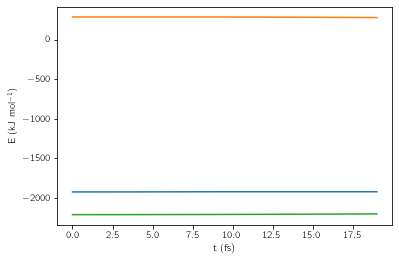

In [337]:
plt.rc('text', usetex=False)
plt.plot(time,total_energy)
plt.plot(time,kinetic_energy)
plt.plot(time,potential_energy)
plt.xlabel(r't (fs)')
plt.ylabel(r'E (kJ mol$^{-1}$)')

Text(0, 0.5, 'E (kJ mol$^{-1}$)')

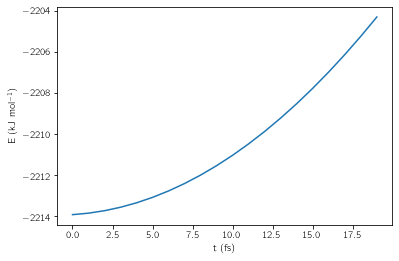

In [338]:
plt.rc('text', usetex=False)
plt.plot(time,potential_energy)
plt.xlabel(r't (fs)')
plt.ylabel(r'E (kJ mol$^{-1}$)')

Text(0, 0.5, 'E (kJ mol$^{-1}$)')

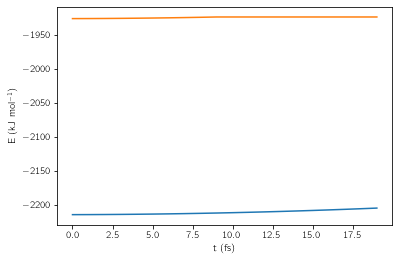

In [339]:
plt.rc('text', usetex=False)
plt.plot(time,potential_energy)
plt.plot(time,total_energy)
plt.xlabel(r't (fs)')
plt.ylabel(r'E (kJ mol$^{-1}$)')